# QRealBoost implementation 

New boosting implementation using QRAM for initialization of x_i and y_i

In [ ]:
from qiskit import *

In [ ]:
import numpy as np
import pandas as pd
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

from qiskit import IBMQ

TOKEN = '14f0d3a62d85ab2df8cd73f3f81ce48dfb99526e83b946755d16a0ab451357fc886cee8a704a5256fb1e6849c8f186d74edf47501bc3239266c68e86bae7076b'

IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = provider.get_backend('simulator_mps')

from sklearn.cluster import KMeans

In [ ]:
import math
from QRAM_lib import QRAM
from QAA_lib import Amplitude_Amplification

ibmqfactory.load_account:WARNING:2022-01-22 02:55:33,989: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np

### Helper functions

In [ ]:
def flip_string(x):
    return x[::-1]

In [ ]:
def Oh_Dbk_custom(qc, qr1, qr2, data_dict):
    reg1_len = qr1.size
    reg2_len = qr2.size
    data_size = len(data_dict)
#     qc.x(qr1)
    # for application of mct we need an array which takes in all the qubits from qr1... [qr1[0],qr1[1],qr1[2]...]
    qr1_arr = []
    
    for i in range(reg1_len):
        qr1_arr.append(qr1[i])
    
    # application of the main gates that there are 
    
    for i in range(data_size):
        string1 = flip_string(list(data_dict.keys())[i])
        string2 = flip_string(list(data_dict.values())[i])
        #print(string1)
        #print(string2)
        
        # the main idea is that the oracle looks at the all the values of xi and the corresponding jti that it wanna 
        # attach, then it makes the state 11111.. and applies a mct to make this control and target is applied on jti
        # finally we apply X to make the states back to the original xi's
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])
        
        for j in range(len(string2)):
            if string2[j] == '1':
                qc.mct(qr1_arr, qr2[j])
#         qc.mct([qr_x[0],qr_x[1],qr_x[2],qr_x[3],qr_x[4]], qr_c[1])
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])
    

In [ ]:
def check_j():
    
    j_i = QuantumRegister(2,'j_i')
    k = QuantumRegister(2, 'k')
    qq = QuantumRegister(2, 'qq')
    i_1 = QuantumRegister(1,'i_1')

    qc = QuantumCircuit(j_i, k, qq, i_1, name = 'label j')
    
    qc.x(j_i[0])
    qc.x(j_i[1])
    
#     qc.x(k[0])
#     qc.x(k[1])
    
    qc.cx(j_i[0] ,k[0])
    qc.cx(j_i[1] ,k[1])
    
    qc.cx(k[0],qq[0])
    qc.cx(k[1],qq[1])

    qc.ccx(qq[0],qq[1],i_1)

#     qc.x(i_1)
    
#     qc.x(k[0])
#     qc.x(k[1])

    qc.cx(j_i[0] ,k[0])
    qc.cx(j_i[1] ,k[1])
    
    qc.x(j_i[0])
    qc.x(j_i[1])
    
    return qc

In [ ]:
def check_y():
    
    y = QuantumRegister(1,'j_i')
    b = QuantumRegister(1, 'b')
    i_2 = QuantumRegister(1,'i_2')

    qc = QuantumCircuit(b,y, i_2, name = 'check y')

    qc.cx(y, b)
    qc.cx(b, i_2)
    qc.x(i_2)
    
    qc.cx(y, b)
    
    return qc

#### Initialisation of values of K and b

When we store 2 it stores in the form $q_1 q_0$ = 1 0. So normal binary form of the decimal value in the opposite of qiskit order. 

Note - make sure to encode the $j^t_i$ in the same way, while making the Oh.

In [ ]:
def new_qc( mc, data):
    
    qr_m = QuantumRegister(mc)
    #cr = ClassicalRegister(2)
    
    
    qc = QuantumCircuit(qr_m, name = 'init')
    
    ## each of data points should be smaller than 2**mc
    
    for i in range(0,len(data)):
        if data[i]>2**mc:
            print("Error!! The value of the data to be stored is bigger then the 2**mc")
            return
    
    bin_data = ["" for x in range(len(data))]
    ## the data needs to convert to binary from decimal
    for i in range(0,len(data)):
        bin_data[i] = decimalToBinary(data[i], mc)
        
    
    new_data = np.zeros([len(data), mc])
    
    # now we will be dividing all our divided
    for i in range(len(data)):
        for j in range(mc):
            new_data[i, j] = bin_data[i][j]
    
    ## fliping the matrix around so the ordering is proper according QISKIT
    flip_new_data = np.flip(new_data,1)
    ## this will be arranged in a row vector so that we can run a loop over it 
    new_data_row = np.reshape(flip_new_data,[1,mc*len(data)])
    
    for i in range(len(new_data_row[0])):
        if new_data_row[0,i] == 1:
            qc.x(qr_m[i])
            
    return qc

In [ ]:
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)
  
     # add zeroes to the end of num1
#     num1 = num1 * (10**digits)
  
     # add num2 to num1
    num1 += num2
  
    return num1

## for convertign from decimal to binary 
def decimalToBinary(n,no_of_places):
    num = no_of_places ## this will be equal to mc
    binary = bin(n).replace("0b", "")
    if (len(binary) != num):
        i = num - len(binary)
        for j in range(0,i):
            binary = numConcat(0,binary)

    return binary

In [ ]:
def dec_to_bin(n, size):
    bin_num = '0'*size
    b = bin(int(n)).replace("0b", "" )
    l = len(b)
    bin_num = bin_num[:size-l] + b
    return bin_num

In [ ]:
def f2bin(number,places): 
  

  if(type(number)==int ):
    return bin(number).lstrip("0b") + "."+"0"*places

  else:
    whole, dec = str(number).split(".") 

    whole = int(whole)

    dec = "0."+dec
    
    stri = ''
  
    res = bin(whole).lstrip("0b") + "."
    
    dec= float(dec)
    
    dec_val2 = dec
    
    num = dec
    
    countlen= 0
    
    while(dec_val2 != 0 and countlen <= places):
        
        num = float(num)*2
#         print(num)
        arr = str(num).split(".")
        
        if (len(arr)==2):
            whole1 = arr[0]
            dec_val = arr[1]
        else:
            whole1 = arr[0]
            dec_val = '0'
        
        if whole1 == '0':
            stri = stri + '0'
        else:
            stri = stri+ '1'

#         print(dec_val)
        dec_val2 = float(dec_val)
        num = '0.'+dec_val
#         print(num)

        countlen = len(stri)
    
    if (len(stri)<= places):
        stri = stri + '0'*(places - len(stri))
    elif(len(stri)>= places):
        stri = stri[:places]
    else:
        stri = stri
        
    s = str(whole)+'.'+stri
    
    return s

#### Conditional Rotations

The function given below is used to do conditional rotations, used for encoding Dti's. Since we're encoding Dti's within the range of 0.1 to 0.99, if we use pi as the scaling angle, we'll be able to encode approximately the same values using this rot circuit

In [ ]:
def rot_circuit():
    
    theta = np.pi
    num_qubits = 9
    qc = QuantumCircuit(num_qubits, name = 'rot_circuit')
    qc.cry(theta/2,0,8)
    qc.cry(theta/4,1,8)
    qc.cry(theta/8,2,8)
    qc.cry(theta/16,3,8)
    qc.cry(theta/32,4,8)
    qc.cry(theta/64,5,8)
    qc.cry(theta/128,6,8)
    qc.cry(theta/256,7,8)

    return qc

# Implementation

## **Dataset**

In [ ]:
import sklearn
from sklearn import svm

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

### Old Datasets

Origianlly we were plannning to do digit recognition and classification on the basis of the digit in the image is either bigger than 0 or not. But our partitions were also made on the basis of being '0','1' or '2'. Due to which the samples in the same partitons have the same labels. 

The idea is to use wine data set and to do partitioning into three partitions,now this would reflect the country of origin, and then we will be doing a classification of how harmful the wine is to the body, now this will be done on my hypothesis of a few things mainly, how high are a few chemicals are in the wine(now this is totally hypothecial and has no scientific basis, but will give us lbels)

Read more from [here](https://archive.ics.uci.edu/ml/datasets/wine)

### New Data set

Right Now we're using the Breast Cancer prediction dataset which has binary labels

In [ ]:
cancer = datasets.load_breast_cancer()

# X = iris.data[:, :4]  # our feature vector
# parts = iris.target # partitions


# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     cancer.data, cancer.target, test_size=0.2, random_state=22)

train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

# we get the labels now from the label train itself

n_dim = 1
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 32
X = sample_train[:train_size]
y = label_train[:train_size]
# parts = y # now we do the partitioning using binary classification  


## testing data 
test_size = 32
X_test = sample_train[train_size:train_size + test_size]
y_test = label_train[train_size:train_size + test_size]
# print(X)

### Testing 

I will perform testing using X_test and y_test which have been stored here

In [ ]:
y_test

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1])

In [ ]:
X_test

array([[-0.43718958],
       [-0.70223061],
       [-0.21042604],
       [-0.62472476],
       [-0.59752814],
       [-0.56281699],
       [-0.13628088],
       [-0.91596535],
       [-0.82458988],
       [-0.51078153],
       [ 0.25418665],
       [ 0.07375224],
       [-0.52341311],
       [-0.19819817],
       [ 0.02474395],
       [-0.36465364],
       [-0.13698308],
       [-0.5778909 ],
       [-0.44634766],
       [-0.17638324],
       [-0.5409153 ],
       [-0.03666943],
       [-0.64786361],
       [-0.88399539],
       [-0.70179728],
       [-0.72180275],
       [ 0.67367406],
       [ 0.84995371],
       [-0.87184544],
       [-0.57793596],
       [-0.32486821],
       [-0.79210158]])

This function inputs the Xi, Yi and Wti (Weights at particular iteration and gets the partition predictions from classifier. For now we'll use classical classifier, later we'll use Quantum one and create a seperate function for it, so that we just call these functions inside our quantum boosting algo functions and let them be generalized.

In [ ]:
def get_ht(X,  Dti, no_of_Q):
    
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]
    
    # now we will pass the corresponding X and parts with the Q samples to train the model 
    
    # try the clus mbr of partitions as 3

#     no of paritions 
    no_of_paritons = 3
    km = KMeans(
        n_clusters=no_of_paritons, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )

    
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X)
    d = prediction

    # acc=np.mean(parts==d)
    # print('Accuracy: %.3f'% (acc))
#     scores = sklearn.metrics.accuracy_score(parts, list(d))

    return  d, prediction

This was the updated version according to the old classifier where we could also use testing data to get predictions, but now we don't have to do that, we're now using Clustering algo in which testing has a different method

In [ ]:
def get_ht_new(X, test_data, Dti, no_of_Q):
    
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]
    
    # now we will pass the corresponding X and parts with the Q samples to train the model 
    
    # try the clus mbr of partitions as 3

#     no of paritions 
    no_of_paritons = 3
    km = KMeans(
        n_clusters=no_of_paritons, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )

    
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X)
    d = prediction


    return  d

## Data for QRAM

In [ ]:
xi =  np.array(range(32))#["" for x in range(32)]

xi_bin = ["" for x in range(32)]
for i in range(len(xi)):
    xi_bin[i] = str(decimalToBinary(xi[i],5))
    
ram_data =["" for x in range(32)]
dec_qram_data = ["" for x in range(32)]

for i in range(len(xi)):
    ram_data[i] =  str(y[i]) + xi_bin[i] 

for i in range(len(xi)):
    dec_qram_data[i] = binaryToDecimal(int(ram_data[i]))

# Original distribution

This function will tell us about the distribution of the things the classification data after clustering is performed at each iteration

In [ ]:
def original_distribution(parts, y):

    arr0_0 = []
    arr0_1 = []
    arr1_0 = []
    arr1_1= []
    arr2_0 = []
    arr2_1 = []


    for i in range(len(parts)):
        if parts[i] == 0 and y[i] == 0:
            print()
            arr0_0.append(i)
        if parts[i] == 0 and y[i] == 1:
            arr0_1.append(i)
        if parts[i] == 1 and y[i] == 0:
            arr1_0.append(i)
        if parts[i] == 1 and y[i] == 1:
            arr1_1.append(i)
        if parts[i] == 2 and y[i] == 0:
            arr2_0.append(i)
        if parts[i] == 2 and y[i] == 1:
            arr2_1.append(i)


    print("no. of things in partitions")
    print("0,0 -" , len(arr0_0))
    print("0,1 -" , len(arr0_1))
    print("1,0 -" , len(arr1_0))
    print("1,1 -" , len(arr1_1))
    print("2,0 -" , len(arr2_0))
    print("2,1 -" , len(arr2_1))

This updated version also prints the sum of $D^{bk}_{ti}$ values to get a rough idea if wkb values are correct or not

In [ ]:
def original_distribution(parts, y, dti):

    dti0_0 = []
    dti0_1 = []
    dti1_0 = []
    dti1_1= []
    dti2_0 = []
    dti2_1 = []


    for i in range(len(parts)):
        if parts[i] == 0 and y[i] == 0:
            dti0_0.append(dti[i])
        if parts[i] == 0 and y[i] == 1:
            dti0_1.append(dti[i])
        if parts[i] == 1 and y[i] == 0:
            dti1_0.append(dti[i])
        if parts[i] == 1 and y[i] == 1:
            dti1_1.append(dti[i])
        if parts[i] == 2 and y[i] == 0:
            dti2_0.append(dti[i])
        if parts[i] == 2 and y[i] == 1:
            dti2_1.append(dti[i])


    print("Classically calculated Dti for cross checking")
    print("0,0 -" , len(dti0_0), "sum - ", sum(dti0_0))
    print("0,1 -" , len(dti0_1), "sum - ", sum(dti0_1))
    print("1,0 -" , len(dti1_0), "sum - ", sum(dti1_0))
    print("1,1 -" , len(dti1_1), "sum - ", sum(dti1_1))
    print("2,0 -" , len(dti2_0), "sum - ", sum(dti2_0))
    print("2,1 -" , len(dti2_1), "sum - ", sum(dti2_1))

This is where everything is happening till the creation of the state $|\psi_6>$

In [ ]:
def A(no_of_address_qubits,no_of_bits_in_memory_cell, data ,k , b, preds, Dti):
    w=Dti
    # print("prediction",preds)
    # print("accuracy", acc)
    qc_ram = QRAM(no_of_address_qubits,no_of_bits_in_memory_cell, data, init_arr = 'extract_all') # xi and yi will remain same in each iteration
    
    # initializing the registers required
    reg = qc_ram.width() - 6
    qr_ram = QuantumRegister(reg, 'qram')
    qr_xi = QuantumRegister(5, 'xi')
    qr_yi = QuantumRegister(1, 'yi')
    qr_Dti = QuantumRegister(8, 'dti')
    qr_jti = QuantumRegister(2, 'jti')
    qr_i_1 = QuantumRegister(1,'i_1')# for I1 and I2
    qr_i_2 = QuantumRegister(1,'i_2')
    qr_kk = QuantumRegister(2,'k')# these are for initilaization of different k and b
    qr_b = QuantumRegister(1,'b')
    qr_Dbk = QuantumRegister(8, 'dbk')
    qr_qq = QuantumRegister(2, 'qq')
    qr_final_rot = QuantumRegister(1,  'final_rot')
    cr = ClassicalRegister(1)#5+8+1+2+1+1+1+2+8+2)
    
    qc = QuantumCircuit(qr_ram,qr_xi,qr_yi, qr_Dti, qr_jti, qr_i_1, qr_i_2, qr_kk, qr_b,qr_Dbk, qr_qq, qr_final_rot, cr)#,cr)
    
#     here we will make the list for appending the QRAM
    lis = list(range(0,qc_ram.width()-6))
    for i in range(0,5):
        lis.append(qr_xi[i])
    lis.append(qr_yi[0])
    
    
    qc = qc.compose(qc_ram, lis)
#     qc = qc.compose(Ud_1(),[qr_Dti[0], qr_Dti[1], qr_Dti[2], qr_Dti[3], qr_Dti[4]])
    
    listofUd={}

    
    for i in range(len(X)):
        
        listofUd[dec_to_bin(i, qr_xi.size)] = flip_string(f2bin(Dti[i] ,qr_Dti.size)[2:10])
    print(listofUd)
    
    # application of Ud
#     print(listofUd)

    Oh_Dbk_custom(qc,qr_xi,qr_Dti,listofUd)
    
    ### here we define the Oh Dbk custom 
    listofOh = {}
    for i in range(len(X)):
        listofOh[dec_to_bin(i, qr_xi.size)] = dec_to_bin(preds[i],qr_jti.size)

        
    Oh_Dbk_custom(qc,qr_xi,qr_jti,listofOh)
    
#     qc = qc.compose(Oh(),[qr_xi[0],qr_xi[1],qr_xi[2],qr_xi[3],qr_xi[4],qr_jti[0],qr_jti[1]])
    qc = qc.compose(new_qc(2,[k]), [qr_kk[0],qr_kk[1]])
    qc = qc.compose(new_qc(1,[b]), [qr_b[0]])
    qc = qc.compose(check_j(),[qr_jti[0],qr_jti[1],qr_kk[0],qr_kk[1],qr_qq[0],qr_qq[1],qr_i_1[0]])
    qc = qc.compose(check_y(), [qr_yi[0], qr_b[0], qr_i_2[0]])
    
    # copying dbkti
    for i in range(8):
        qc.mct([qr_Dti[i],qr_i_1[0],qr_i_2[0]],qr_Dbk[i])
    
    qc = qc.compose(rot_circuit(),[qr_Dbk[0],qr_Dbk[1],qr_Dbk[2],qr_Dbk[3],qr_Dbk[4],qr_Dbk[5],qr_Dbk[6],qr_Dbk[7],qr_final_rot[0]])
    
    # qc = qc.compose(check_y().inverse(), [qr_yi[0], qr_b[0], qr_i_2[0]])
    # qc = qc.compose(check_j().inverse(),[qr_jti[0],qr_jti[1],qr_kk[0],qr_kk[1],qr_qq[0],qr_qq[1],qr_i_1[0]])
    # qc = qc.compose(new_qc(1,[b]).inverse(), [qr_b[0]])
    # qc = qc.compose(new_qc(2,[k]).inverse(), [qr_kk[0],qr_kk[1]])
    # qc = qc.compose(Oh().inverse(),[qr_xi[0],qr_xi[1],qr_xi[2],qr_xi[3],qr_xi[4],qr_jti[0],qr_jti[1]])
    # qc = qc.compose(Ud_1().inverse(),[qr_Dti[0], qr_Dti[1], qr_Dti[2], qr_Dti[3], qr_Dti[4]])
    # qc = qc.compose(qc_ram.inverse(), lis)
    
#    qc.measure(list(range(reg,reg+5+5+1+2+1+1+1+2+5+2)),list(range(0,5+5+1+2+1+1+1+2+5+2)))
#    qc.measure([qr_xi[0],qr_xi[1],qr_xi[2],qr_xi[3],qr_xi[4],qr_yi[0],qr_jti[0],qr_jti[1]],[0,1,2,3,4,5,6,7])

    qc.measure(qr_final_rot[0], 0)
    
    return qc

**Note -** Here the ordering in which you will get counts is bin(jti),yi,bin(xi) . For checking of jti the classes are 0,1,2 and bin(jti) = new_qc(bin)

In [ ]:
def iteration(no_of_address_qubits,no_of_bits_in_memory_cell, data, preds,Dti):
    w = Dti
    wkb = []
    wp = []
    wn = []
    beta_j = []
    Zt = 0
    for k in range(0,3):

      print('k value -', k)
        ## doing for label 0
      qq = A(no_of_address_qubits,no_of_bits_in_memory_cell, data,k,0, preds,Dti)

      shots = 1000
      result = execute(qq, backend, shots = shots).result()
      answers = result.get_counts()

      if(answers['0']!=shots):
          #print('k = ', k)
          #print('b =', b)
          wkb.append(answers['1'])
          #print(wkb)
          #print('--------------------------------------------------------------------------------------------')
          
          wn.append(answers['1'])
          den = answers['1']/shots

      else:
          den = 1e-8 #smoothing
          wn.append(den)

        ## doing for label 1
      q2 = A(no_of_address_qubits,no_of_bits_in_memory_cell, data,k,1,preds, Dti)

      result = execute(q2, backend, shots = shots).result()
      answers = result.get_counts()

      if(answers['0']!=shots):
          #print('k = ', k)
          #print('b =', b)
          wkb.append(answers['1'])
          #print(wkb)
          #print('--------------------------------------------------------------------------------------------')
            
          wp.append(answers['1'])
          num = answers['1']/shots

      else:
          num = 1e-8 #smoothing
          wp.append(num)

      num = np.sqrt(num)
      den = np.sqrt(den)
         
      b = (1/2)*np.log(num/den)

      beta_j.append(b)

      Zt = Zt+ (np.sqrt(num*den))
          ## testing 
        
      print("w for b =0,", den)
      print("w for b =1," , num)
    

    Zt = 2*Zt
    
    return beta_j, Zt

In [ ]:
def get_ht_test(X, Dti, no_of_Q):
    
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]
#     print(ind_max)
    # now we will pass the corresponding X and parts with the Q samples to train the model 
    
    # try the clus mbr of partitions as 3

#     no of paritions 
    no_of_paritons = 3
    km = KMeans(
        n_clusters=no_of_paritons, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )

    
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X)
    d = prediction


    return  d, fitted_km

In [ ]:
def update_dti(no_of_address_qubits,no_of_bits_in_memory_cell, data, X,test_data, Dti, y):
    print("------------------------------------------------------------------------------------")

    ## as the Dti should approximate to 1
    Dti1 = Dti/sum(Dti) 
    Dti_norm = normalize(Dti1, 0.1390625,0.99609375 ) # here we will apply the logarithmic scale in order to fit it on our system
    
    print(Dti_norm)
    # running the classical classifier
    no_of_Q = 16
    #model, acc = get_ht(X, parts, Dti, 16) # this gives us the values of partitions obtained after training weights with w_i
    preds = get_ht_new(X, test_data, Dti_norm, no_of_Q)
    
    print(preds)
    print(original_distribution(preds,y))
    # Dti_rescaled = rescaler2(Dti)
    beta_j,Zt = iteration(no_of_address_qubits,no_of_bits_in_memory_cell, data,  preds, Dti_norm)#_rescaled)

    dti_up = []
    
    dtiii = Dti_norm
    
    final_beta = []
    
    for i in range(len(Dti)):
        if(preds[i]==0):
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[0])/Zt)
            
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[0])/Zt)
            final_beta.append(beta_j[0])

        elif(preds[i]==1):
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[1])/Zt)
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[1])/Zt)
            final_beta.append(beta_j[1])

        else:
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[2])/Zt)
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[2])/Zt)
            final_beta.append(beta_j[2])

    return dti_up,beta_j, final_beta, preds

### Rescalers 

There are two main problems for which we need these - 

1. The values passed to our classifiers as weights do not have much difference between them due to which we need to increase the diff3rence so that our Dti's will make some difference in the predictions

2. We have used 8 qubits for encoding of Dti due to which we are not able to encode the values of Dti that do not come in the range 0.00390625 - 0.99609375. So the other rescaler does normalization to the spacific values given in between.

This function straight away removes all the consecutive zeros after the decimal point in Dti values

In [ ]:
# explicit function to normalize array
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)  
    if diff_arr == 0:
        arr_1 = np.ones(len(arr))*(t_max+t_min)/2
        return arr_1
        
    else:

        for i in arr:
            temp = (((i - min(arr))*diff)/diff_arr) + t_min
            norm_arr.append(temp)

        return norm_arr

In [ ]:
def complete_imp(num_iterations,data,X,test_data,y):
    
    no_of_address_qubits =5
    no_of_bits_in_memory_cell = 6
    
    # all the arrays
    Dti = np.full(32,1/32)
    
    #change labels from 0,1 to -1,1
    y_mod = []
    for i in range(len(y)):
        if y[i]==0:
            y_mod.append(-1)
        else:
            y_mod.append(1)

    dti = []
    beta = []
    accuracy_final = []
    
    for itr in range(num_iterations):

        dtii0,beta0,final_beta0,preds0 = update_dti(no_of_address_qubits,no_of_bits_in_memory_cell, data, X,test_data, Dti, y)
        print(dtii0)
        dti.append(dtii0)
        beta.append(final_beta0)
        print(beta)
        final_bin, acc = final_bin_predictions(test_data,y_mod,Dti,beta)
        print("New Binary labels : ", final_bin)
        print("New Accuracy : ", acc)
        accuracy_final.append(acc)
        
        Dti = dtii0
    
    import matplotlib.pyplot as plt
    from matplotlib import style
    
    plt.style.use('seaborn')
    plt.plot(list(range(num_iterations)), accuracy_final)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.show()
    
    return dti, beta, accuracy_final

# Predict

The training of the boosting algorithm provides us with the value of $D^t_i$'s. The prediction after each iteration would get better using the combination of the weights. Now we need a function which uses all these weights and creates a better result

this function gets the H(x) after each iteration

In [ ]:
def final_bin_predictions(X,y_mod,Dti,betas):
    
    Hx = np.sum(betas, axis = 0)
    
    final_bin = []

    for j in range(len(Hx)):
        if np.sign(Hx[j]) == -1:
            final_bin.append(-1)
        if np.sign(Hx[j]) == 1:
            final_bin.append(1)

#     original_preds, original_acc = get_ht(X,y, np.full(len(X), 1/len(X))) #original predictions and accuracy of weak classifier
#     get_ht_new(X, test_data, parts, Dti, no_of_Q)

#     dtree_model_parts = DecisionTreeClassifier(max_depth = 2) .fit(X, y)
#     # prediction will be obtained for all the samples
#     dtree_predictions_parts = dtree_model_parts.predict(X)
#     d = dtree_predictions_parts
    
    acc = metrics.accuracy_score(final_bin, y_mod)
    
    
    return final_bin, acc

In [ ]:
test_data = X

# Running 

With all the points in 1 and 2 to have label - 1 and in 0 have label 0

# **Training Accuracy**

------------------------------------------------------------------------------------
[0.56757813 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813
 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813
 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813
 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813
 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813
 0.56757813 0.56757813]
[1 2 1 0 1 0 0 2 2 0 1 0 0 0 1 2 0 2 1 1 0 2 1 0 0 0 2 0 1 1 0 1]
no. of things in partitions
0,0 - 0
0,1 - 14
1,0 - 6
1,1 - 5
2,0 - 7
2,1 - 0
None
k value - 0
{'00000': '10001001', '00001': '10001001', '00010': '10001001', '00011': '10001001', '00100': '10001001', '00101': '10001001', '00110': '10001001', '00111': '10001001', '01000': '10001001', '01001': '10001001', '01010': '10001001', '01011': '10001001', '01100': '10001001', '01101': '10001001', '01110': '10001001', '01111': '10001001', '10000': '10001001', '10001': '10001001', '10010': '1000100

{'00000': '10001001', '00001': '10001001', '00010': '10001001', '00011': '10001001', '00100': '10001001', '00101': '10001001', '00110': '10001001', '00111': '10001001', '01000': '10001001', '01001': '10001001', '01010': '10001001', '01011': '10001001', '01100': '10001001', '01101': '10001001', '01110': '10001001', '01111': '10001001', '10000': '10001001', '10001': '10001001', '10010': '10001001', '10011': '10001001', '10100': '10001001', '10101': '10001001', '10110': '10001001', '10111': '10001001', '11000': '10001001', '11001': '10001001', '11010': '10001001', '11011': '10001001', '11100': '10001001', '11101': '10001001', '11110': '10001001', '11111': '10001001'}
w for b =0, 0.0001
w for b =1, 0.5128352561983234
k value - 1
{'00000': '10001001', '00001': '10001001', '00010': '10001001', '00011': '10001001', '00100': '10001001', '00101': '10001001', '00110': '10001001', '00111': '10001001', '01000': '10001001', '01001': '10001001', '01010': '10001001', '01011': '10001001', '01100': '10

w for b =0, 0.19493588689617927
w for b =1, 0.0001
k value - 2
{'00000': '00111011', '00001': '00100100', '00010': '00111011', '00011': '11000100', '00100': '00111011', '00101': '11000100', '00110': '11000100', '00111': '00100100', '01000': '00100100', '01001': '11000100', '01010': '11111111', '01011': '11000100', '01100': '11000100', '01101': '11000100', '01110': '00111011', '01111': '00100100', '10000': '11000100', '10001': '00100100', '10010': '00111011', '10011': '11111111', '10100': '11000100', '10101': '00100100', '10110': '11111111', '10111': '11000100', '11000': '11000100', '11001': '11000100', '11010': '00100100', '11011': '11000100', '11100': '11111111', '11101': '11111111', '11110': '11000100', '11111': '00111011'}
{'00000': '00111011', '00001': '00100100', '00010': '00111011', '00011': '11000100', '00100': '00111011', '00101': '11000100', '00110': '11000100', '00111': '00100100', '01000': '00100100', '01001': '11000100', '01010': '11111111', '01011': '11000100', '01100': '1

w for b =0, 0.11401754250991379
w for b =1, 0.30495901363953815
[0.7118853062902284, 0.21819801040277123, 0.7118853062902284, 0.005137554769533965, 0.7118853062902284, 0.005137554769533965, 0.005137554769533965, 0.21662582708331832, 0.21819801040277123, 0.29172566545938045, 1.1336817297860213, 0.005137554769533965, 0.005137554769533965, 0.005137554769533965, 0.23874925584952073, 0.21819801040277123, 0.005137554769533965, 0.21819801040277123, 0.7118853062902284, 1.1336817297860213, 0.005137554769533965, 0.21819801040277123, 0.5801370713454643, 0.005137554769533965, 0.005137554769533965, 0.005137554769533965, 0.21662582708331832, 0.005137554769533965, 0.5801370713454643, 0.5801370713454643, 0.29172566545938045, 0.7118853062902284]
[[-0.08496695640558777, -4.129217942728922, -0.08496695640558777, 4.271269874286999, -0.08496695640558777, 4.271269874286999, 4.271269874286999, -4.129217942728922, -4.129217942728922, 4.271269874286999, -0.08496695640558777, 4.271269874286999, 4.27126987428699

{'00000': '01111101', '00001': '11000100', '00010': '01111101', '00011': '00000010', '00100': '01111101', '00101': '00000010', '00110': '00000010', '00111': '10001110', '01000': '11000100', '01001': '10001110', '01010': '11111111', '01011': '00000010', '01100': '00000010', '01101': '00000010', '01110': '10101110', '01111': '11000100', '10000': '00000010', '10001': '11000100', '10010': '01111101', '10011': '11111111', '10100': '00000010', '10101': '11000100', '10110': '01001001', '10111': '00000010', '11000': '00000010', '11001': '00000010', '11010': '10001110', '11011': '00000010', '11100': '01001001', '11101': '10000101', '11110': '10001110', '11111': '01111101'}
w for b =0, 0.28809720581775866
w for b =1, 0.260768096208106
k value - 1
{'00000': '01111101', '00001': '11000100', '00010': '01111101', '00011': '00000010', '00100': '01111101', '00101': '00000010', '00110': '00000010', '00111': '10001110', '01000': '11000100', '01001': '10001110', '01010': '11111111', '01011': '00000010', 

{'00000': '11111001', '00001': '11000100', '00010': '11111001', '00011': '10111100', '00100': '11111111', '00101': '10111100', '00110': '10111100', '00111': '00100100', '01000': '11000100', '01001': '00001010', '01010': '01010001', '01011': '10111100', '01100': '10111100', '01101': '10111100', '01110': '00100100', '01111': '11000100', '10000': '10111100', '10001': '11000100', '10010': '11111001', '10011': '01010001', '10100': '10111100', '10101': '11000100', '10110': '00110001', '10111': '10111100', '11000': '10111100', '11001': '10111100', '11010': '00100100', '11011': '10111100', '11100': '00110001', '11101': '11101001', '11110': '00001010', '11111': '11111001'}
w for b =0, 0.0001
w for b =1, 0.282842712474619
k value - 1
{'00000': '11111001', '00001': '11000100', '00010': '11111001', '00011': '10111100', '00100': '11111111', '00101': '10111100', '00110': '10111100', '00111': '00100100', '01000': '11000100', '01001': '00001010', '01010': '01010001', '01011': '10111100', '01100': '101

{'00000': '11010101', '00001': '00111010', '00010': '11010101', '00011': '11000100', '00100': '11111111', '00101': '11000100', '00110': '11000100', '00111': '01111010', '01000': '00111010', '01001': '00100100', '01010': '11101111', '01011': '11000100', '01100': '11000100', '01101': '11000100', '01110': '01111010', '01111': '00111010', '10000': '11000100', '10001': '00111010', '10010': '11010101', '10011': '11101111', '10100': '11000100', '10101': '00111010', '10110': '00101001', '10111': '11000100', '11000': '11000100', '11001': '11000100', '11010': '01111010', '11011': '11000100', '11100': '00101001', '11101': '10111001', '11110': '00100100', '11111': '11010101'}
w for b =0, 0.21908902300206645
w for b =1, 0.0001
k value - 1
{'00000': '11010101', '00001': '00111010', '00010': '11010101', '00011': '11000100', '00100': '11111111', '00101': '11000100', '00110': '11000100', '00111': '01111010', '01000': '00111010', '01001': '00100100', '01010': '11101111', '01011': '11000100', '01100': '1

{'00000': '11101101', '00001': '11000100', '00010': '11101101', '00011': '00000010', '00100': '11111111', '00101': '00000010', '00110': '00000010', '00111': '11000100', '01000': '11000100', '01001': '00000010', '01010': '10101111', '01011': '00000010', '01100': '00000010', '01101': '00000010', '01110': '11000100', '01111': '11000100', '10000': '00000010', '10001': '11000100', '10010': '11101101', '10011': '10101111', '10100': '00000010', '10101': '11000100', '10110': '00000101', '10111': '00000010', '11000': '00000010', '11001': '00000010', '11010': '11000100', '11011': '00000010', '11100': '00000101', '11101': '00010101', '11110': '00000010', '11111': '11101101'}
w for b =0, 0.0001
w for b =1, 0.18708286933869708
k value - 1
{'00000': '11101101', '00001': '11000100', '00010': '11101101', '00011': '00000010', '00100': '11111111', '00101': '00000010', '00110': '00000010', '00111': '11000100', '01000': '11000100', '01001': '00000010', '01010': '10101111', '01011': '00000010', '01100': '0

{'00000': '00000011', '00001': '10000010', '00010': '00000011', '00011': '11000100', '00100': '11111111', '00101': '11000100', '00110': '11000100', '00111': '10000010', '01000': '10000010', '01001': '11000100', '01010': '11100100', '01011': '11000100', '01100': '11000100', '01101': '11000100', '01110': '10000010', '01111': '10000010', '10000': '11000100', '10001': '10000010', '10010': '00000011', '10011': '11100100', '10100': '11000100', '10101': '10000010', '10110': '00101111', '10111': '11000100', '11000': '11000100', '11001': '11000100', '11010': '10000010', '11011': '11000100', '11100': '00101111', '11101': '01111111', '11110': '11000100', '11111': '00000011'}
w for b =0, 0.17320508075688773
w for b =1, 0.0001
k value - 1
{'00000': '00000011', '00001': '10000010', '00010': '00000011', '00011': '11000100', '00100': '11111111', '00101': '11000100', '00110': '11000100', '00111': '10000010', '01000': '10000010', '01001': '11000100', '01010': '11100100', '01011': '11000100', '01100': '1

{'00000': '10110101', '00001': '11000100', '00010': '10110101', '00011': '10000010', '00100': '01011011', '00101': '10000010', '00110': '10000010', '00111': '11000100', '01000': '11000100', '01001': '10000010', '01010': '00100010', '01011': '10000010', '01100': '10000010', '01101': '10000010', '01110': '10001010', '01111': '11000100', '10000': '10000010', '10001': '11000100', '10010': '10110101', '10011': '00100010', '10100': '10000010', '10101': '00100100', '10110': '01101111', '10111': '10000010', '11000': '10000010', '11001': '10000010', '11010': '11000100', '11011': '10000010', '11100': '01101111', '11101': '11111111', '11110': '10000010', '11111': '10110101'}
w for b =0, 0.0001
w for b =1, 0.22135943621178655
k value - 1
{'00000': '10110101', '00001': '11000100', '00010': '10110101', '00011': '10000010', '00100': '01011011', '00101': '10000010', '00110': '10000010', '00111': '11000100', '01000': '11000100', '01001': '10000010', '01010': '00100010', '01011': '10000010', '01100': '1

{'00000': '01101001', '00001': '10100010', '00010': '01101001', '00011': '01011010', '00100': '00101101', '00101': '11000100', '00110': '11000100', '00111': '10100010', '01000': '10100010', '01001': '01011010', '01010': '10111010', '01011': '11000100', '01100': '11000100', '01101': '11000100', '01110': '11001110', '01111': '10100010', '10000': '11000100', '10001': '10100010', '10010': '01101001', '10011': '10111010', '10100': '11000100', '10101': '11100010', '10110': '11101111', '10111': '11000100', '11000': '11000100', '11001': '11000100', '11010': '10100010', '11011': '11000100', '11100': '10001101', '11101': '11111111', '11110': '01011010', '11111': '01101001'}
w for b =0, 0.05477225575051661
w for b =1, 0.0001
k value - 1
{'00000': '01101001', '00001': '10100010', '00010': '01101001', '00011': '01011010', '00100': '00101101', '00101': '11000100', '00110': '11000100', '00111': '10100010', '01000': '10100010', '01001': '01011010', '01010': '10111010', '01011': '11000100', '01100': '1

{'00000': '00010101', '00001': '01011010', '00010': '00010101', '00011': '00001110', '00100': '11000011', '00101': '11111100', '00110': '11111100', '00111': '01011010', '01000': '01011010', '01001': '00001110', '01010': '01001110', '01011': '11111100', '01100': '11111100', '01101': '11111100', '01110': '11111110', '01111': '01011010', '10000': '11111100', '10001': '01011010', '10010': '00010101', '10011': '01001110', '10100': '11111100', '10101': '11000100', '10110': '00011111', '10111': '11111100', '11000': '11111100', '11001': '11111100', '11010': '01011010', '11011': '11111100', '11100': '11010011', '11101': '01111111', '11110': '00001110', '11111': '00010101'}
w for b =0, 0.22583179581272428
w for b =1, 0.3361547262794322
k value - 1
{'00000': '00010101', '00001': '01011010', '00010': '00010101', '00011': '00001110', '00100': '11000011', '00101': '11111100', '00110': '11111100', '00111': '01011010', '01000': '01011010', '01001': '00001110', '01010': '01001110', '01011': '11111100',

{'00000': '00110011', '00001': '00100100', '00010': '00000111', '00011': '11101110', '00100': '01111111', '00101': '11001010', '00110': '11001010', '00111': '00100100', '01000': '00100100', '01001': '11101110', '01010': '10011110', '01011': '11001010', '01100': '11001010', '01101': '11001010', '01110': '10100100', '01111': '00100100', '10000': '11001010', '10001': '00100100', '10010': '00110011', '10011': '10011110', '10100': '11001010', '10101': '11000100', '10110': '10101111', '10111': '11001010', '11000': '11001010', '11001': '11001010', '11010': '00100100', '11011': '11001010', '11100': '11110011', '11101': '01011111', '11110': '11101110', '11111': '00110011'}
w for b =0, 0.0001
w for b =1, 0.21213203435596426
k value - 1
{'00000': '00110011', '00001': '00100100', '00010': '00000111', '00011': '11101110', '00100': '01111111', '00101': '11001010', '00110': '11001010', '00111': '00100100', '01000': '00100100', '01001': '11101110', '01010': '10011110', '01011': '11001010', '01100': '1

{'00000': '11000101', '00001': '10011100', '00010': '11110101', '00011': '00100100', '00100': '01000011', '00101': '11000100', '00110': '11000100', '00111': '10011100', '01000': '10011100', '01001': '00100100', '01010': '00100100', '01011': '11000100', '01100': '11000100', '01101': '11000100', '01110': '10011100', '01111': '10011100', '10000': '11000100', '10001': '10011100', '10010': '11000101', '10011': '00100100', '10100': '11000100', '10101': '00011100', '10110': '01011111', '10111': '11000100', '11000': '11000100', '11001': '11000100', '11010': '10011100', '11011': '11000100', '11100': '00011011', '11101': '11111111', '11110': '00100100', '11111': '11000101'}
w for b =0, 0.06324555320336758
w for b =1, 0.0001
k value - 1
{'00000': '11000101', '00001': '10011100', '00010': '11110101', '00011': '00100100', '00100': '01000011', '00101': '11000100', '00110': '11000100', '00111': '10011100', '01000': '10011100', '01001': '00100100', '01010': '00100100', '01011': '11000100', '01100': '1

{'00000': '10000011', '00001': '11000100', '00010': '10110011', '00011': '10000010', '00100': '00000111', '00101': '10000010', '00110': '10000010', '00111': '11000100', '01000': '11000100', '01001': '10000010', '01010': '10000010', '01011': '10000010', '01100': '10000010', '01101': '10000010', '01110': '01011010', '01111': '11000100', '10000': '10000010', '10001': '11000100', '10010': '10000011', '10011': '10000010', '10100': '10000010', '10101': '00100100', '10110': '01011111', '10111': '10000010', '11000': '10000010', '11001': '10000010', '11010': '11000100', '11011': '10000010', '11100': '10111011', '11101': '11111111', '11110': '10000010', '11111': '10000011'}
w for b =0, 0.0001
w for b =1, 0.25099800796022265
k value - 1
{'00000': '10000011', '00001': '11000100', '00010': '10110011', '00011': '10000010', '00100': '00000111', '00101': '10000010', '00110': '10000010', '00111': '11000100', '01000': '11000100', '01001': '10000010', '01010': '10000010', '01011': '10000010', '01100': '1

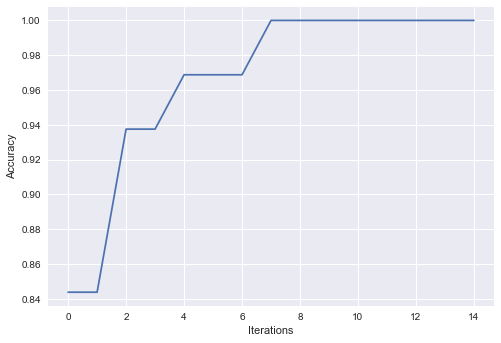

([[0.7925485876675705,
   0.01388768987040249,
   0.7925485876675705,
   0.012048629214710328,
   0.7925485876675705,
   0.012048629214710328,
   0.012048629214710328,
   0.01388768987040249,
   0.01388768987040249,
   0.012048629214710328,
   0.9393496048434101,
   0.012048629214710328,
   0.012048629214710328,
   0.012048629214710328,
   0.7925485876675705,
   0.01388768987040249,
   0.012048629214710328,
   0.01388768987040249,
   0.7925485876675705,
   0.9393496048434101,
   0.012048629214710328,
   0.01388768987040249,
   0.9393496048434101,
   0.012048629214710328,
   0.012048629214710328,
   0.012048629214710328,
   0.01388768987040249,
   0.012048629214710328,
   0.9393496048434101,
   0.9393496048434101,
   0.012048629214710328,
   0.7925485876675705],
  [1.0653618195888541,
   0.005331555838431804,
   1.0653618195888541,
   0.1689873266163782,
   1.0653618195888541,
   0.1689873266163782,
   0.1689873266163782,
   0.0039107156032891326,
   0.005331555838431804,
   0.168987326

In [ ]:
complete_imp(15,dec_qram_data,X,test_data,y)

# **Testing Accuracy**
Here we need to use the Beta_j vales to get get the updated Dti's, and the decision rules of the classifier after each iteration, which will be used to get predictions for new testing data

In [ ]:
 beta_j = [[4.271269874286999, -0.08496695640558777, -4.129217942728922], [-3.47770518444215, -3.7876279061741536, 0.009376098864613484 ],
    [3.8611877744236383, -0.17804884388265993, 0.4919125339229299],[-3.744665341942489, 0.15153395089257887,0.02295188731328071],
    [-0.04983322565512273, 0.5229660154195983, -3.875477377883626],[3.9737380249110275 ,0.34657359027997264, -0.2885455349557301 ],
    [-3.84603161896953,-3.6927555007479276 , 0.007092674282303812 ],[ 3.7670683816149104,-0.2052451380174575,4.00594624287177], 
    [-3.728530711658096,  -3.0515181613825435,-0.0921215262167692],[ 3.851186440770214, -0.128363436543065, 0.26815920056621223],
    [-3.1528844384095844, -0.08039590603186554, 0.016005464691232842 ], [0.19889054649700375 ,0.08771524351832814, -3.8845692889263446 ],
          [3.829896988685137,4.00594624287177, -0.16726240724522123 ], [-3.22480495652253, -3.6829503224596074, 0.05897645073201521],
          [ 3.91401504784044, -0.19136696053489294, 0.16695734314391383]]

In [ ]:
[ -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1]
[1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1]

In [ ]:
def testing(Beta_j, X, y,X_train, y_train, No_of_itr, no_of_Q):
    '''
    here beta_j is the function which is contains the betas in the form - [[beta0,beta1,beta2]itr=1,[beta0,beta1,beta2]itr=2,[beta0,beta1,beta2]itr=3....]
    
    '''
    T = No_of_itr
    ### first we need to find all the classical classifiers 
    Dti = np.full(32,1/32)
    classifiers = []

    
    for i in range(T):
        
        Dti1 = Dti/sum(Dti) 
        Dti_norm = normalize(Dti1, 0.1390625,0.99609375 ) 
        dtiii = Dti_norm
        
        beta_j = Beta_j[i]
#         print(Dti_norm)
        preds, classifier = get_ht_test(X_train, Dti_norm, no_of_Q)
#         print(preds)
        classifiers.append(classifier)
        
        dti_up = []
        
        for i in range(len(Dti)):
            
            if(preds[i]==0):
                if(y_train[i]==0): 
                    dti_up.append(dtiii[i]*np.exp(beta_j[0]))

                else:
                    dti_up.append(dtiii[i]*np.exp(-beta_j[0]))

            elif(preds[i]==1):
                if(y_train[i]==0):
                    dti_up.append(dtiii[i]*np.exp(beta_j[1]))
                else:
                    dti_up.append(dtiii[i]*np.exp(-beta_j[1]))

            else:
                if(y_train[i]==0):
                    dti_up.append(dtiii[i]*np.exp(beta_j[2]))
                else:
                    dti_up.append(dtiii[i]*np.exp(-beta_j[2]))

        Dti = dti_up
    
    
    
    ## now all the clustering models are stored in classifiers
    
#     X = X_train
#     y = y_train
    
    ## getting y_mod
    
    #change labels from 0,1 to -1,1
    y_mod = []
    for i in range(len(y)):
        if y[i]==0:
            y_mod.append(-1)
        else:
            y_mod.append(1)
    
    ## lets do the partitioning to produce domains

    
    Beta_js = []# the array which will store all the betas
    accuracy_final= []
    for i in range(T):
        beta_j = Beta_j[i]
        predst = classifiers[i].predict(X)
        print(predst)
        final_beta =[]
        # updation of dti and distribution of betas
        for i in range(len(Dti)):
            if(predst[i]==0):
                final_beta.append(beta_j[0])

            elif(predst[i]==1):
                final_beta.append(beta_j[1])

            else:
                final_beta.append(beta_j[2])
            
        Beta_js.append(final_beta)
            
            # now lets add up the betas and get H(x)
#         print(len())
        final_bin, acc = final_bin_predictions(X,y_mod,Dti,Beta_js)
        accuracy_final.append(acc)
            
#     print(Beta_js)
    import matplotlib.pyplot as plt
    from matplotlib import style
    
    plt.style.use('seaborn')
    plt.plot(list(range(T)), accuracy_final)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.show()
        
    return Beta_js

In [ ]:
# def final_prediction(Dti,num_itr, betas):
#     #here Dti and betas both will have all the betas and Dti's stored inside of an bigger array 
#     beta_basic = np.zeros(len(Dti[0]))
#     for i in range(num_itr):
#       # beta and dti for a particular iteration
#          dtii = Dti[i]
#          beta = betas[i]

#          # the same training samples and training partitions will be used to get the predictions only the weights will be varied
#          preds, score  = get_ht(X,parts,np.full(len(Dti[0]), 1/len(Dti[0])))
#          get_ht_new(X, test_data, parts, Dti, no_of_Q)
        
#          beta_per_iter = [] # per iteration storage of the values of beta's
         
#          for j in range(dtii):
#             partition = preds[j]
#             # once we have the value of the 
            
# #            label = y[j]

# #            element_index = 2*paritition + label  # this can be observed in the beta(j,k) method

#            beta_per_iter.append(beta[element_index])

#          # add all the beta's 
#         beta_per_iter = beta_per_iter + beta_basic


#     for j in range(len(beta_per_iter)):
#         if np.sign(beta_per_iter[j]) == -1:
#           beta_per_iter[j] = -1
#         if np.sign(beta_per_iter[j]) == 1:
#           beta_per_iter[j] = 1


#     return beta_per_iter

[1 0 2 0 1 1 2 0 0 1 2 2 1 2 2 1 2 1 1 2 1 2 0 0 0 0 2 2 0 1 1 0]
[2 2 1 2 2 2 1 2 2 2 0 0 2 1 0 1 1 2 2 1 2 0 2 2 2 2 0 0 2 2 1 2]
[2 0 2 1 1 1 2 0 0 2 2 2 1 2 2 2 2 1 2 2 1 2 1 0 0 0 2 2 0 1 2 0]
[1 2 1 2 2 2 0 2 2 2 0 0 2 1 0 1 0 2 1 1 2 0 2 2 2 2 0 0 2 2 1 2]
[0 1 2 1 1 0 2 1 1 0 2 2 0 2 2 2 2 1 0 2 0 2 1 1 1 1 2 2 1 1 2 1]
[1 0 1 0 2 2 1 0 0 2 1 1 2 1 1 1 1 2 1 1 2 1 0 0 0 0 1 1 0 2 1 0]
[2 2 1 2 2 2 1 2 2 2 0 0 2 1 0 1 1 2 2 1 2 0 2 2 2 2 0 0 2 2 1 2]
[1 2 1 2 2 1 1 0 0 1 1 1 1 1 1 1 1 2 1 1 1 1 2 0 2 0 1 1 0 2 1 0]
[2 2 0 2 2 2 0 2 2 2 0 0 2 0 0 2 0 2 2 0 2 0 2 2 2 2 1 1 2 2 2 2]
[2 0 2 1 1 1 2 0 0 1 2 2 1 2 2 2 2 1 2 2 1 2 1 0 0 0 2 2 0 1 2 0]
[1 2 1 2 2 2 1 2 2 2 1 1 2 1 1 1 1 2 2 1 2 1 2 2 2 2 0 0 2 2 1 2]
[1 0 2 0 0 0 2 0 0 1 2 2 1 2 2 2 2 0 1 2 1 2 0 0 0 0 2 2 0 0 2 0]
[2 1 2 1 1 2 2 0 0 2 2 2 2 2 2 2 2 1 2 2 2 2 1 0 1 0 2 2 0 1 2 0]
[2 2 1 2 2 2 1 2 2 2 1 1 2 1 1 2 1 2 2 1 2 1 2 2 2 2 0 0 2 2 2 2]
[2 0 2 0 1 1 2 0 0 1 2 2 1 2 2 2 2 1 2 2 1 2 0 0 0 0 2 2 0 1 2 0]


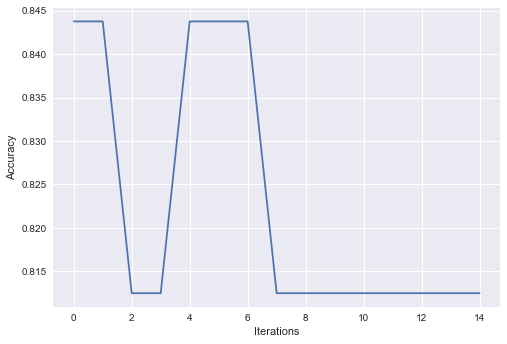

In [ ]:
Beta_js = testing(beta_j, X_test, y_test,X, y, 15, 16)

In [ ]:
beta_j[6]

[-3.84603161896953, -3.6927555007479276, 0.007092674282303812]

In [ ]:
Beta_js[6]

[-3.6927555007479276,
 0.007092674282303812,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 0.007092674282303812,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 0.007092674282303812,
 -3.6927555007479276,
 0.007092674282303812,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.84603161896953,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276,
 -3.6927555007479276]